# Notebook for running ERDiff alignment step by step

In [1]:
from torch.autograd import Variable
from torch.utils.data import DataLoader

import numpy as np
import scipy.signal as signal
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook

import pickle
import random

from model_functions.Diffusion import *
from model_functions.VAE import *
from model_functions.ERDiff_utils import *
from model_functions.MLA_Model import *
from model_functions.VAE_Readout import *

## 1. Source Domain: Training

Extract spatio-temporal structure for source domain  
Code for training is `VAE_Diffusion_CoTrain.py`

### 1.1 Load source domain data

- trial spikes: neural firing rates
- trial vel: velocity
- trial dir: labels of direction, 8 classes

<img src="images/monkey_data.png" width="15%">

In [2]:
# Specify the trial length and number of neurons to use
len_trial,num_neurons = 37, 187

In [3]:
with open('datasets/Neural_Source.pkl', 'rb') as f:
    train_data1 = pickle.load(f)['data']
train_trial_spikes1, train_trial_vel1, train_trial_dir1 = train_data1['firing_rates'], train_data1['velocity'], train_data1['labels']

There are 209 trials, for each trial, the time length to use is 37 (minimal trial length - 1), number of neurons is 187, dimension of velocity is 2.

In [4]:
print("minimal trial length is:", min(train_trial_spikes1[i].shape[0] for i in range(len(train_trial_spikes1))))

minimal trial length is: 38


In [5]:
start_pos = 1 

train_trial_spikes_tide1 = np.array([spike[start_pos:len_trial+start_pos, :num_neurons] for spike in train_trial_spikes1])
print("Shape for training neural signal:", np.shape(train_trial_spikes_tide1))

train_trial_vel_tide1 = np.array([spike[start_pos:len_trial+start_pos, :] for spike in train_trial_vel1])
print("Shape for training velocity:", np.shape(train_trial_vel_tide1))

train_trial_spikes_tide = train_trial_spikes_tide1
train_trial_vel_tide = train_trial_vel_tide1

Shape for training neural signal: (209, 37, 187)
Shape for training velocity: (209, 37, 2)


In [6]:
array_train_trial_dir1 = np.expand_dims(np.array((train_trial_dir1), dtype=object),1)

train_trial_spikes_tide = train_trial_spikes_tide1
train_trial_vel_tide = train_trial_vel_tide1
train_trial_dic_tide = np.squeeze(np.vstack([array_train_trial_dir1]))
print(np.shape(train_trial_dic_tide))

(209,)


### 1.2 Data preprocessing

Apply gaussian smoother  

$$
w(n)=\exp^{-\frac{1}{2}(\frac{n}{\sigma})^2}
$$

`scipy.signal.windows.gaussian(M, std, sym=True)`
```
Parameters:	
- M : int, number of points in the output window. If zero or less, an empty array is returned.
- std : float, the standard deviation, sigma.
- sym : bool, optional, when True (default), generates a symmetric window, for use in filter design. When False, generates a periodic window, for use in spectral analysis.

Returns:	
- w : ndarray, The window, with the maximum value normalized to 1 (though the value 1 does not appear if M is even and sym is True).
```

In [7]:
bin_width = float(0.02) * 1000 # /ms

kern_sd_ms = 100
kern_sd = int(round(kern_sd_ms / bin_width))
print("M = std =", kern_sd)
window = signal.windows.gaussian(kern_sd, kern_sd, sym=True)
window /= np.sum(window)
print("window:", window)

M = std = 5
window: [0.19205063 0.20392638 0.20804597 0.20392638 0.19205063]


Apply convolution filter  

$$(v1 * v2) [n] = \sum v1[m] v2[n-m]$$

In [8]:
filt = lambda x: np.convolve(x, window, 'same')
train_trial_spikes_smoothed = np.apply_along_axis(filt, 1, train_trial_spikes_tide)

Visualize before and after smoothing

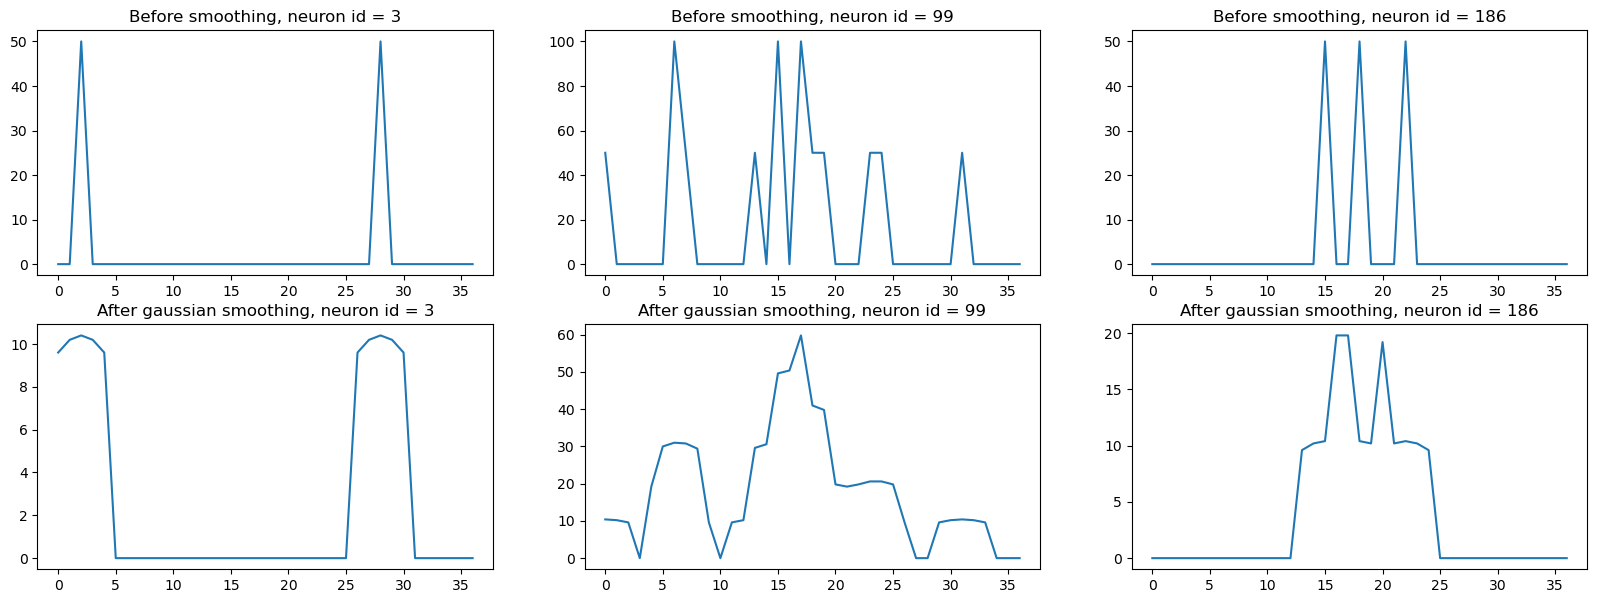

In [9]:
neuron_id_list = [3, 99, 186]
plt.figure(figsize=(20, 7))
for i in range(len(neuron_id_list)):
    neuron_id = neuron_id_list[i]
    ax1 = plt.subplot(2, len(neuron_id_list), i+1)
    ax1.plot(train_trial_spikes_tide[0, :, neuron_id])
    ax1.set_title("Before smoothing, neuron id = " + str(neuron_id))
    ax2 = plt.subplot(2, len(neuron_id_list), i+len(neuron_id_list)+1)
    ax2.plot(train_trial_spikes_smoothed[0, :, neuron_id])
    ax2.set_title("After gaussian smoothing, neuron id = " + str(neuron_id))
plt.show()

### 1.3 Randomly shuffle and split to train and validation set

In [10]:
indices = np.arange(train_trial_spikes_tide.shape[0])
np.random.seed(2023) 
np.random.shuffle(indices)
train_len = round(len(indices) * 0.80)
real_train_trial_spikes_smed, val_trial_spikes_smed = train_trial_spikes_smoothed[indices[:train_len]], train_trial_spikes_smoothed[indices[train_len:]]
real_train_trial_vel_tide, val_trial_vel_tide = train_trial_vel_tide[indices[:train_len]], train_trial_vel_tide[indices[train_len:]]
real_train_trial_dic_tide, val_trial_dic_tide = train_trial_dic_tide[indices[:train_len]], train_trial_dic_tide[indices[train_len:]]

In [11]:
real_train_trial_spikes_stand = (real_train_trial_spikes_smed)
val_trial_spikes_stand = (val_trial_spikes_smed)

spike_train = Variable(torch.from_numpy(real_train_trial_spikes_stand)).float()
spike_val = Variable(torch.from_numpy(val_trial_spikes_stand)).float()

emg_train = Variable(torch.from_numpy(real_train_trial_vel_tide)).float()
emg_val = Variable(torch.from_numpy(val_trial_vel_tide)).float()

### 1.4 Experiment settings

In [12]:
n_epochs = 500
batch_size = 16
global_batch_size = 16
ae_res_weight = 10 # scale for spike reconstruction loss
kld_weight = 1 # scale for KL-Divergence loss
n_batches = len(real_train_trial_spikes_smed)//batch_size
print("number of batches:", n_batches)

mse_criterion = nn.MSELoss()
poisson_criterion = nn.PoissonNLLLoss(log_input=False)

l_rate = 0.001 # learning rate
timesteps = 50

number of batches: 10


### 1.5 Build the model

<img src="images/training.png" width="50%">


In [13]:
# Loss function, AE reconstruction loss, emg loss, kl-divergence loss
def get_loss(model, spike, emg):
    re_sp_, vel_hat_, mu, log_var = model(spike, train_flag= True)
    ae_loss = poisson_criterion(re_sp_, spike)
    emg_loss = mse_criterion(vel_hat_, emg)
    kld_loss = torch.mean(0.5 * (- log_var + mu ** 2 + log_var.exp() - 1))
    total_loss = ae_res_weight * ae_loss + emg_loss + kld_weight * kld_loss
    return total_loss

In [14]:
# Training
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
# setup_seed(21)
setup_seed(666)

In [15]:
# VAE model
model = VAE_Model()
optimizer = torch.optim.Adam(model.parameters(), lr=l_rate)

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"

input_dim = 1

dm_model = diff_STBlock(input_dim)
dm_model.to(device)

dm_optimizer = Adam(dm_model.parameters(), lr=1e-3)

/home/cheny/anaconda3/envs/torch/lib/python3.11/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


### 1.6 Train

In [17]:
pre_loss = 1e10 # Save the loss
pre_total_loss_ = 1e18
vae_loss_list = []
diff_loss_list = []

In [18]:
for epoch in tqdm_notebook(range(n_epochs)):
    spike_gen_obj = get_batches(real_train_trial_spikes_stand,batch_size)
    emg_gen_obj = get_batches(real_train_trial_vel_tide,batch_size)
    for ii in range(n_batches):
        optimizer.zero_grad()
        spike_batch = next(spike_gen_obj)
        emg_batch = next(emg_gen_obj)

        spike_batch = Variable(torch.from_numpy(spike_batch)).float()
        emg_batch = Variable(torch.from_numpy(emg_batch)).float()

        # Loss
        batch_loss = get_loss(model, spike_batch, emg_batch)

        batch_loss.backward()
        optimizer.step()
        

    with torch.no_grad():
        val_total_loss = get_loss(model, spike_val, emg_val)
        vae_loss_list.append(val_total_loss.item())

        _, _, train_latents, _ = model(spike_train, train_flag = False)

        if val_total_loss < pre_total_loss_: 
            pre_total_loss_ = val_total_loss
            torch.save(model.state_dict(),'model_checkpoints/source_vae_model')


            np.save("./npy_files/train_latents.npy",train_latents)

        
    train_latents = np.expand_dims(train_latents,1).astype(np.float32)
    train_spike_data = train_latents.transpose(0,1,3,2)

    dataloader = DataLoader(train_spike_data, batch_size=global_batch_size)

    total_loss = 0
    for step, batch in enumerate(dataloader):
        dm_optimizer.zero_grad()

        batch_size = batch.shape[0]
        batch = batch.to(device)

        # generate diffusion timesteps (noise scale) for each batch from range
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()

        loss = p_losses(dm_model, batch, t)

        print("Step", step, " Loss:", loss.item())
        total_loss += loss.item()

        loss.backward()
        dm_optimizer.step()

    print("total Loss of epoch ", epoch+1, " is ", total_loss)
    diff_loss_list.append(total_loss)

    if total_loss < pre_loss:
        pre_loss = total_loss
        torch.save(dm_model.state_dict(), 'model_checkpoints/source_diffusion_model')

/tmp/ipykernel_4182394/1429026334.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


  0%|          | 0/500 [00:00<?, ?it/s]

Step 0  Loss: 0.805607259273529
Step 1  Loss: 0.8093595504760742
Step 2  Loss: 0.8114948868751526
Step 3  Loss: 0.8081263899803162
Step 4  Loss: 0.7949563264846802
Step 5  Loss: 0.7903522849082947
Step 6  Loss: 0.771514892578125
Step 7  Loss: 0.7764241695404053
Step 8  Loss: 0.7684854865074158
Step 9  Loss: 0.7585070133209229
Step 10  Loss: 0.763283371925354
total Loss of epoch  1  is  8.65811163187027
Step 0  Loss: 0.748495876789093
Step 1  Loss: 0.7381426692008972
Step 2  Loss: 0.7686977982521057
Step 3  Loss: 0.7259146571159363
Step 4  Loss: 0.7536355257034302
Step 5  Loss: 0.7140335440635681
Step 6  Loss: 0.7314398288726807
Step 7  Loss: 0.7261727452278137
Step 8  Loss: 0.6774146556854248
Step 9  Loss: 0.715463399887085
Step 10  Loss: 0.618971586227417
total Loss of epoch  2  is  7.918382287025452
Step 0  Loss: 0.6707600951194763
Step 1  Loss: 0.6793172359466553
Step 2  Loss: 0.638113260269165
Step 3  Loss: 0.6213526129722595
Step 4  Loss: 0.6277210712432861
Step 5  Loss: 0.5464614

### 1.7 Plot loss curve

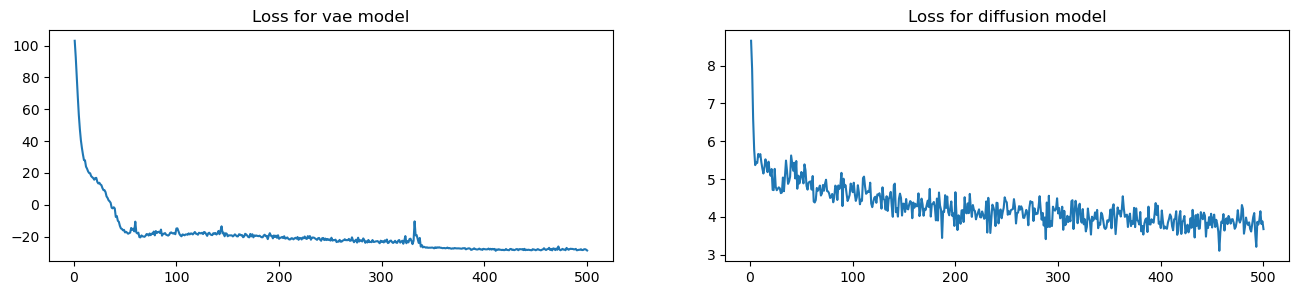

In [19]:
plt.figure(figsize=(16, 3))
ax1 = plt.subplot(1, 2, 1)
ax1.set_title("Loss for vae model")
ax1.plot(range(1, len(vae_loss_list)+1), vae_loss_list)
ax2 = plt.subplot(1, 2, 2)
ax2.set_title("Loss for diffusion model")
ax2.plot(range(1, len(diff_loss_list)+1), diff_loss_list)
plt.show()

## 2. Target domain: Maximum Likelihood Alignment

### 2.1 Load the data and preparing (same as in source domain)

In [20]:
len_trial, num_neurons_s, num_neurons_t = 37, 187, 172

In [21]:
with open('datasets/Neural_Target.pkl', 'rb') as f:
    test_data = pickle.load(f)['data']
test_trial_spikes, test_trial_vel, test_trial_dir = test_data['firing_rates'], test_data['velocity'], np.squeeze(test_data['labels'])

In [22]:
test_trial_spikes_tide = np.array([spike[:len_trial, :num_neurons_t] for spike in test_trial_spikes])
print("Shape for test neural signal:", np.shape(test_trial_spikes_tide))

test_trial_vel_tide = np.array([spike[:len_trial, :] for spike in test_trial_vel])
print("Shape for test velocity:",np.shape(test_trial_vel_tide))

Shape for test neural signal: (184, 37, 172)
Shape for test velocity: (184, 37, 2)


In [23]:
test_trial_spikes_smoothed = np.apply_along_axis(filt, 1, test_trial_spikes_tide)
test_trial_spikes_stand = (test_trial_spikes_smoothed)
spike_test = Variable(torch.from_numpy(test_trial_spikes_stand)).float()

In [24]:
test_trial_spikes_stand_half_len = len(test_trial_spikes_stand) // 2

spike_day_0 = Variable(torch.from_numpy(real_train_trial_spikes_stand)).float()
spike_day_k = Variable(torch.from_numpy(test_trial_spikes_stand[:test_trial_spikes_stand_half_len])).float()

num_x, num_y, num_y_test = spike_day_0.shape[0], spike_day_k.shape[0], test_trial_spikes_stand.shape[0]

p = Variable(torch.from_numpy(np.full((num_x, 1), 1 / num_x))).float()
q = Variable(torch.from_numpy(np.full((num_y, 1), 1 / num_y))).float()
q_test = Variable(torch.from_numpy(np.full((num_y_test, 1), 1 / num_y_test))).float()

### 2.2 Define hyperparameters

In [25]:
n_epochs = 500
epoches = 300
batch_size = 64
timesteps = 50
eps = 1 / timesteps
channels = 1
input_dim = 1
pre_total_loss_ = 1e18
l_rate = 1e-3

### 2.3 Load the model

In [26]:
def logger_performance(model):
    re_sp_test, vel_hat_test, _, _, _, _,_ = model(spike_train, spike_test, p, q_test, train_flag=False)

    sys.stdout.flush()
    # print(test_trial_vel_tide.reshape((-1,2)))
    # print(vel_hat_test.reshape((-1,2)))
    key_metric = 100 * r2_score(test_trial_vel_tide.reshape((-1,2)),vel_hat_test.reshape((-1,2)), multioutput='uniform_average')
    return  key_metric

In [27]:
diff_model = diff_STBlock(input_dim)
diff_model_dict = torch.load('model_checkpoints/source_diffusion_model')
diff_model.load_state_dict(diff_model_dict)
for k,v in diff_model.named_parameters():
    v.requires_grad=False

In [28]:
setup_seed(21)
# vanilla_model_dict = torch.load('model_checkpoints_old/source_vae_model')
vanilla_model_dict = torch.load('model_checkpoints/source_vae_model')
MLA_model = VAE_MLA_Model()
MLA_dict_keys = MLA_model.state_dict().keys()
vanilla_model_dict_keys = vanilla_model_dict.keys()

MLA_dict_new = MLA_model.state_dict().copy()

for key in vanilla_model_dict_keys:
    MLA_dict_new[key] = vanilla_model_dict[key]

MLA_model.load_state_dict(MLA_dict_new)

<All keys matched successfully>

In [29]:
optimizer_mla = torch.optim.Adam(MLA_model.parameters(), lr=l_rate)
criterion = nn.MSELoss()
poisson_criterion = nn.PoissonNLLLoss(log_input=False)

In [30]:
for param in MLA_model.vde_rnn.parameters():
    param.requires_grad = False

for param in MLA_model.sde_rnn.parameters():
    param.requires_grad = False
    
for param in MLA_model.encoder_rnn.parameters():
    param.requires_grad = False

MLA_model.low_d_readin_s.weight.requires_grad = False
MLA_model.low_d_readin_s.bias.requires_grad = False
MLA_model.fc_mu_1.weight.requires_grad = False
MLA_model.fc_mu_1.bias.requires_grad = False
MLA_model.fc_log_var_1.weight.requires_grad = False
MLA_model.fc_log_var_1.bias.requires_grad = False
MLA_model.sde_fc1.weight.requires_grad = False
MLA_model.sde_fc1.bias.requires_grad = False
MLA_model.sde_fc2.weight.requires_grad = False
MLA_model.sde_fc2.bias.requires_grad = False
MLA_model.vde_fc_minus_0.weight.requires_grad = False

### 2.4 Maximum Likelihood Alignment

In [31]:
key_metric = -1000
appro_alpha = 1.2

In [32]:
total_loss_list = []
for epoch in range(epoches):

    optimizer_mla.zero_grad()

    re_sp, _, distri_0, distri_k, latents_k, output_sh_loss, log_var = MLA_model(spike_day_0, spike_day_k, p, q, train_flag=True)

    total_loss = output_sh_loss

    latents_k = latents_k[:, None, :, :]
    latents_k = torch.transpose(latents_k,3,2)

    batch_size = latents_k.shape[0]
    t = torch.randint(0, timesteps, (batch_size,), device="cpu").long()
    noise = torch.randn_like(latents_k)

    z_noisy = q_sample(x_start=latents_k, t=t, noise=noise)
    predicted_noise = diff_model(z_noisy, t)
    total_loss += appro_alpha * F.smooth_l1_loss(noise, predicted_noise)
    
    total_loss += skilling_divergence(z_noisy,latents_k,t)

    total_loss.backward(retain_graph=True)
    optimizer_mla.step()

    total_loss_list.append(total_loss.item())

    with torch.no_grad():
        if (epoch % 5 == 0) or (epoch == n_epochs-1):
            print(f"epoch={epoch}, total loss is: {total_loss.item()}")
            current_metric = float(logger_performance(MLA_model))
            if current_metric > key_metric:
                key_metric = current_metric
            if total_loss < pre_total_loss_:
                torch.save(MLA_model.state_dict(),'model_checkpoints/vae_model_mla')
                pre_total_loss_ = total_loss 

epoch=0, total loss is: 0.4863131046295166
epoch=5, total loss is: 0.3599171042442322
epoch=10, total loss is: 0.33607372641563416
epoch=15, total loss is: 0.3363809585571289
epoch=20, total loss is: 0.33670905232429504
epoch=25, total loss is: 0.2727524936199188
epoch=30, total loss is: 0.27465903759002686
epoch=35, total loss is: 0.29001760482788086
epoch=40, total loss is: 0.2996833026409149
epoch=45, total loss is: 0.2626350224018097
epoch=50, total loss is: 0.2749139964580536
epoch=55, total loss is: 0.23657718300819397
epoch=60, total loss is: 0.2660725712776184
epoch=65, total loss is: 0.2657026946544647
epoch=70, total loss is: 0.25032928586006165
epoch=75, total loss is: 0.2414194792509079
epoch=80, total loss is: 0.26087063550949097
epoch=85, total loss is: 0.24362172186374664
epoch=90, total loss is: 0.2473956197500229
epoch=95, total loss is: 0.2473282665014267
epoch=100, total loss is: 0.21542488038539886
epoch=105, total loss is: 0.24013465642929077
epoch=110, total loss 

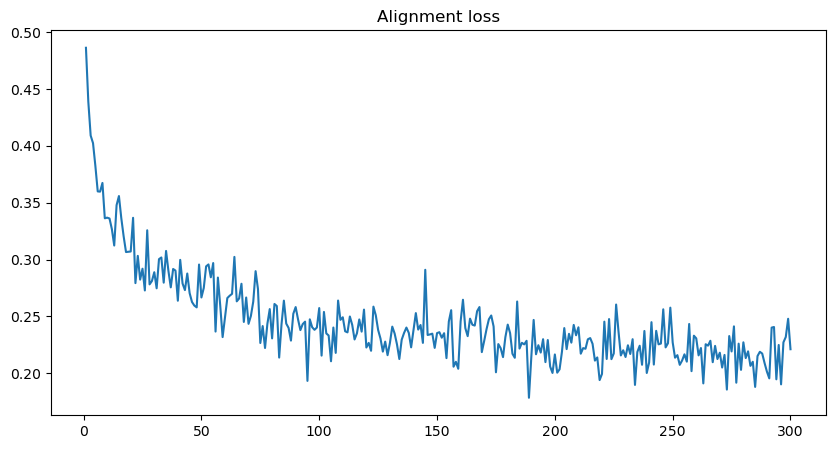

In [33]:
plt.figure(figsize=(10, 5))
plt.title("Alignment loss")
plt.plot(range(1, len(total_loss_list)+1), total_loss_list)
plt.show()

In [34]:
vanilla_model_dict = torch.load('model_checkpoints/vae_model_mla')

MLA_model = VAE_MLA_Model()

MLA_model.load_state_dict(vanilla_model_dict)

with torch.no_grad():
    _, _, _, _, test_latents, _,_ = MLA_model(spike_train, spike_test,p,q_test, train_flag = False)
test_latents = np.array(test_latents)
np.save("./npy_files/test_latents.npy",test_latents)

In [35]:
def create_dir_dict(trial_dir):
    dir_dict = {}
    for i, dir in enumerate(trial_dir):
        dir = dir[0][0]
        if not np.isnan(dir):
            if dir not in dir_dict:
                dir_dict[dir] = [i]
            else:
                dir_dict[dir].append(i)
    return dir_dict

train_dir_dict, test_dir_dict = create_dir_dict(real_train_trial_dic_tide), create_dir_dict(test_trial_dir)
val_dir_dict = create_dir_dict(val_trial_dic_tide)

In [36]:
vanilla_model_dict = torch.load('model_checkpoints/vae_model_mla')

VAE_Readout_model = VAE_Readout_Model()
DL_dict_keys = VAE_Readout_model.state_dict().keys()
vanilla_model_dict_keys = vanilla_model_dict.keys()

DL_dict_new = VAE_Readout_model.state_dict().copy()

for key in vanilla_model_dict_keys:
    DL_dict_new[key] = vanilla_model_dict[key]

VAE_Readout_model.load_state_dict(DL_dict_new)

vel_cal(test_trial_vel_tide, VAE_Readout_model, test_latents)

Aligned R**2:-21.76461296529527
Aligned RMSE:9.801764413687026


### 2.5 Visualization

In [37]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)

In [38]:
train_latents.shape # (n_trials, _, n_timesteps, latent_dimension)

(167, 1, 37, 8)

In [39]:
train_latents_pca = train_latents.reshape(-1, train_latents.shape[-1])
pca.fit(train_latents_pca)

PCA(n_components=3)

In [40]:
train_latents_transform = pca.transform(train_latents_pca)
train_latents_show = train_latents_transform.reshape(train_latents.shape[0], train_latents.shape[2], -1)

In [41]:
test_latents_pca = test_latents.reshape(-1, test_latents.shape[-1])
test_latents_transform = pca.transform(test_latents_pca)
test_latents_show = test_latents_transform.reshape(test_latents.shape[0], test_latents.shape[1], -1)

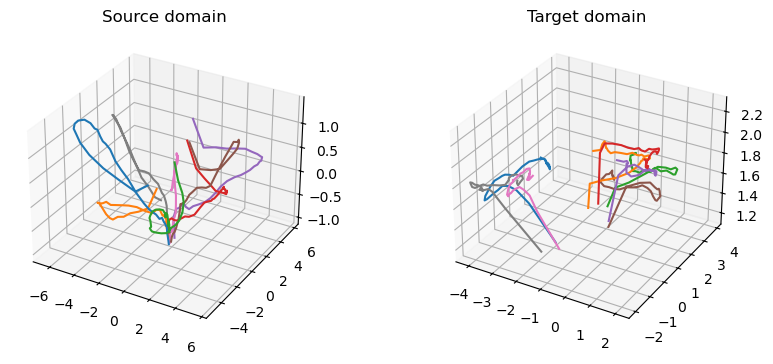

In [42]:
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_title("Source domain")
for key in train_dir_dict.keys(): # direction
    direction = int(key)
    trials = train_dir_dict[key]
    trajectory = np.mean(train_latents_show[trials, :, :], axis=0)
    ax1.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], c=colors[direction])
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title("Target domain")
for key in test_dir_dict.keys(): # direction
    direction = int(key)
    trials = test_dir_dict[key]
    trajectory = np.mean(test_latents_show[trials, :, :], axis=0)
    ax2.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], c=colors[direction])
plt.show()

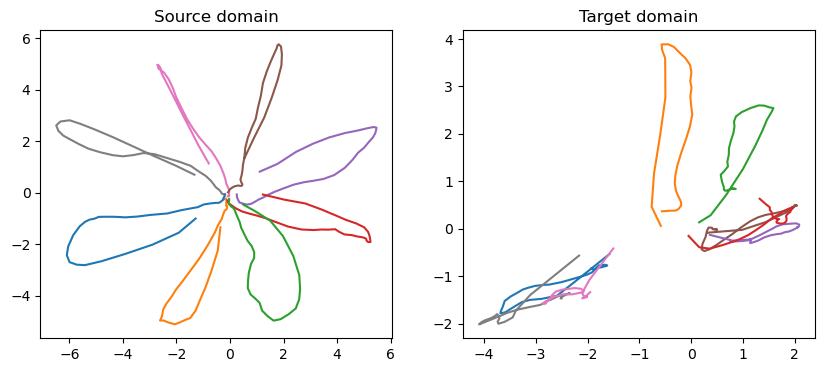

In [43]:
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
ax1.set_title("Source domain")
for key in train_dir_dict.keys(): # direction
    direction = int(key)
    trials = train_dir_dict[key]
    trajectory = np.mean(train_latents_show[trials, :, :], axis=0)
    ax1.plot(trajectory[:, 0], trajectory[:, 1], c=colors[direction])
ax2 = fig.add_subplot(122)
ax2.set_title("Target domain")
for key in test_dir_dict.keys(): # direction
    direction = int(key)
    trials = test_dir_dict[key]
    trajectory = np.mean(test_latents_show[trials, :, :], axis=0)
    ax2.plot(trajectory[:, 0], trajectory[:, 1], c=colors[direction])
plt.show()